# Inferring a common rate

In [2]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf

INFO:bayesflow:Using backend 'jax'

In this section we will estimate a common binomial rate that produces
two binomial processes according to the following model:

### Simulator

The individual components of the model are very similar to a combination
of the previous two examples: Now we have one binomial proportion but
two binomial outcomes.

In [3]:
def context():
    return dict(n=np.random.randint(1, 101, size=2))

def prior():
    return dict(theta=np.random.beta(a=1, b=1))

def likelihood(n, theta):
    return dict(k=np.random.binomial(n=n, p=theta))

simulator=bf.make_simulator([context, prior, likelihood])

### Approximator

In [8]:
adapter = (
    bf.Adapter()
    .constrain("theta", lower=0, upper=1)
    .rename("theta", "inference_variables")
    .concatenate(["k", "n"], into="inference_conditions")
)

In [9]:
workflow=bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow()
)

### Training

In [ ]:
history=workflow.fit_online(epochs=20, batch_size=512)

### Validation

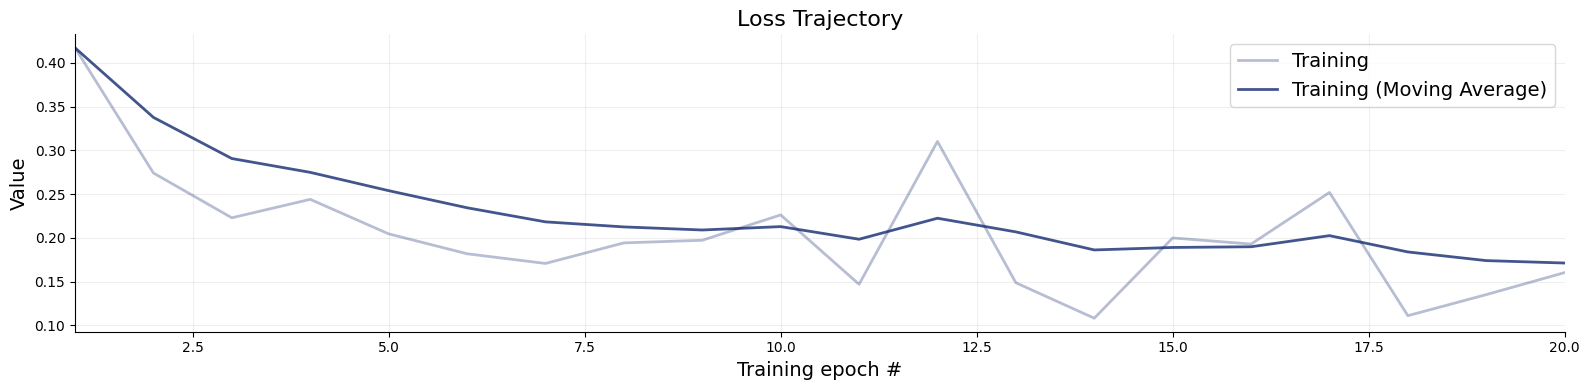

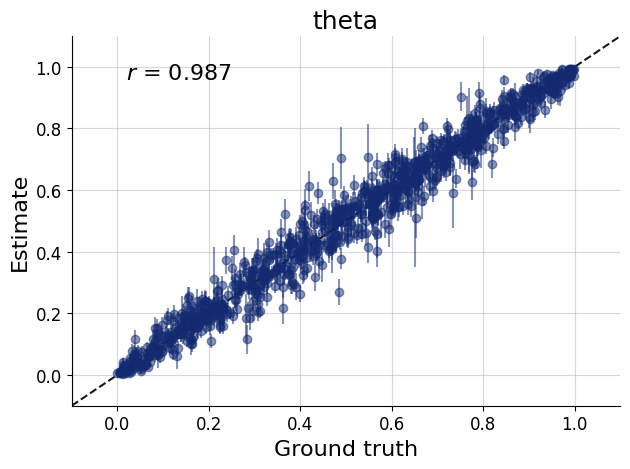

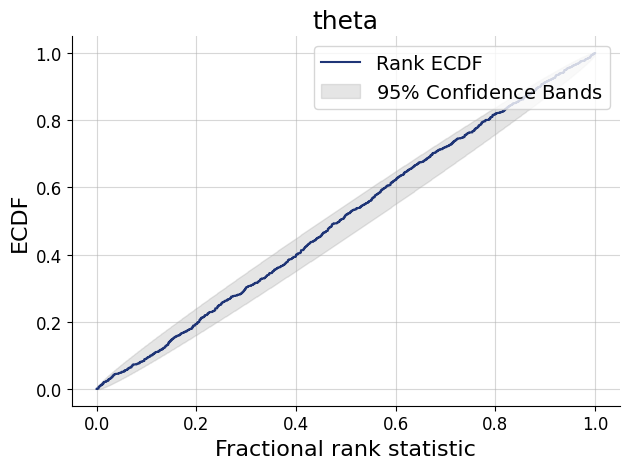

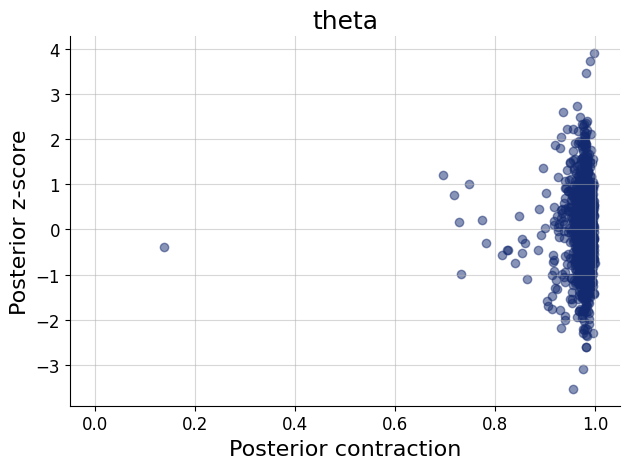

In [12]:
test_data=simulator.sample(1000)
figs=workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

Now that we trained the network we can use it for inference. We are
given four data sets by Lee & Wagenmakers (2013):

1.  $k_1 = 14$, $k_2 = 16$, $n_1 = n_2 = 20$
2.  $k_1 = 0$, $k_2 = 10$, $n_1 = n_2 = 10$
3.  $k_1 = 7$, $k_2 = 3$, $n_1 = n_2 = 10$
4.  $k_1 = k_2 = 5$, $n_1 = n_2 = 10$

The advantage of BayesFlow is that we can obtain the samples for these
three independent data sets *at once*. We simply define an array of data
sets that are passed to the inference network.

In [18]:
inference_data=dict(
    k = np.array([[14, 16], [0, 10], [7, 3], [5, 5]]),
    n = np.array([[20, 20], [10, 10], [10, 10], [10, 10]])
)

In [19]:
samples=workflow.sample(num_samples=2000, conditions=inference_data)

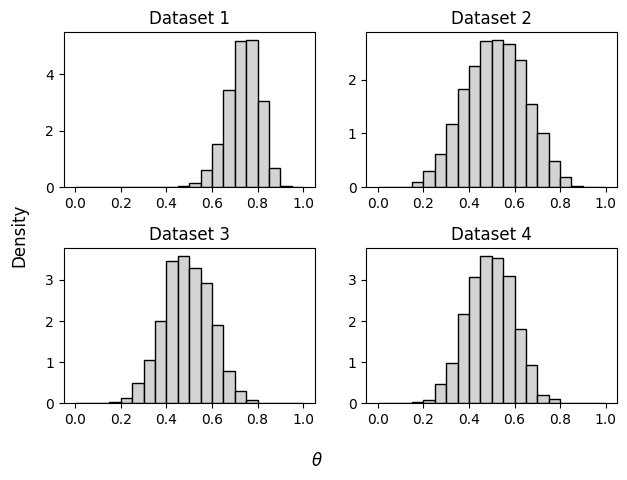

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=2)
axs=axs.flatten()

for i, ax in enumerate(axs):
    ax.set_title("Dataset " + str(i + 1))
    ax.hist(samples["theta"][i], 
            density=True, color="lightgray", edgecolor="black", bins=np.arange(0, 1.05, 0.05))

fig.supxlabel(r"$\theta$")
fig.supylabel("Density")
fig.tight_layout()

Lee, M. D., & Wagenmakers, E.-J. (2013). *Bayesian Cognitive Modeling: A
Practical Course*. Cambridge University Press.